In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os

# Lade Merkmal-Daten

In [116]:
from enum import Enum

class tableNames(Enum):
    features_sampleData= "features_sampleData"
    top40k_19_20_features = "top40k_19_20_features"
    
current_table = tableNames.top40k_19_20_features.value

In [117]:
filename = '{}.json'.format(current_table)

if filename not in os.listdir("./data"):
    %env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json 
    client = bigquery.Client()
    tableName = 'masterarbeit-245718.ethereum_us.{}'.format(current_table)
    query = "SELECT * from `" + tableName+"`"; 
    query_job = client.query(query);
    start = time.time();
    data = query_job.result().to_dataframe();  
    featureValues = data.drop("address", axis=1)
    addresses = data["address"]
    done = time.time();
    elapsed = round(done - start);
    print("Time to retrieve data from BigQuery: {} Seconds.".format(elapsed))
    with open('./data/{}'.format(filename), 'w') as json_file:
        json.dump(featureValues.to_dict(), json_file, use_decimal=True)
else: 
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
    featureValues = pd.DataFrame(file_content_json)

In [119]:
m = featureValues.memory_usage();
totalBytes = m.sum();
totalMegabytes = totalBytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(totalMegabytes)))

Size of the account feature dataset: 99.0 Megabytes.


In [120]:
featureValues.head()

,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenReceivedTransactions,avgTimeDiffBetweenSentTransactions
0,64572707724292084343,2100000000000000000,72,183,2.067153e+05,8.064602e+04
1,22826275150000000000,22820255143989436000,34,33,1.103977e+05,1.138457e+05
2,187998869327720446268,169701857223000000000,157,130,1.739006e+05,9.711747e+04
3,38675545150000000000,38671263720395686800,25,25,1.111308e+06,1.111304e+06
4,186823189770000000420,138950000000000000000,867,848,9.660497e+02,9.875667e+02


# avgTimeDiff Null Values auf max * 2 setzen

In [256]:
featureValues["avgTimeDiffBetweenSentTransactions"] = featureValues["avgTimeDiffBetweenSentTransactions"].replace(to_replace=0.0, value=2 * max(featureValues["avgTimeDiffBetweenSentTransactions"]))
featureValues["avgTimeDiffBetweenReceivedTransactions"] = featureValues["avgTimeDiffBetweenReceivedTransactions"].replace(to_replace=0.0, value=2 * max(featureValues["avgTimeDiffBetweenReceivedTransactions"]))

# Merkmalsausprägungen standardisieren, so dass Mittelwert und Standardabweichung für alle Merkmale gleich sind 

In [257]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
featureValues_std = scaler.fit_transform(featureValues);
featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
featureValues_std.index = featureValues.index

# Use Isolationforest to remove outliers

In [258]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(max_samples="auto", behaviour='new', contamination="auto")
# clf.fit(featureValues_std)
# pred = clf.predict(featureValues_std)
# pred = pd.Series(pred)
# pred.index = featureValues.index
# featureValues_std_out = featureValues_std[pred == 1]
# featureValues_out = featureValues[pred == 1]
# print("Number of detected and deleted outliers: {}".format(pred.value_counts()[-1]))

In [259]:
#  addresses[pred == -1]

### Problem: Isolation forest haut mir die exchanges als Gruppe raus. 

# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [260]:
minExplainedVariance = 0.9

In [261]:
pca = PCA().fit(featureValues_std)
optimalNumberOfClusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimalNumberOfClusters = optimalNumberOfClusters + 1
    if i > minExplainedVariance:
        break;

text = "Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimalNumberOfClusters, minExplainedVariance*100);
display(text)

'Die 3 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.'

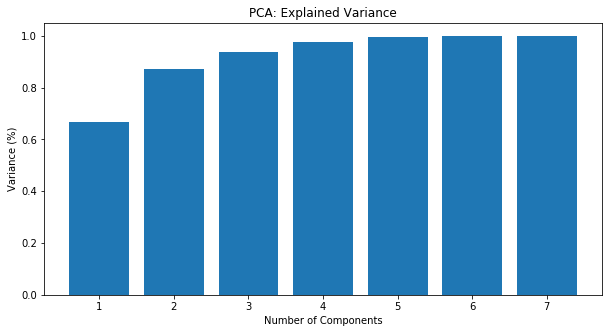

In [262]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()
plt.close()

In [263]:
pca = PCA(n_components=optimalNumberOfClusters);
featureValues_std_pca = pca.fit_transform(featureValues_std);
featureValues_std_pca = pd.DataFrame(featureValues_std_pca);
featureValues_std_pca.index = featureValues.index
featureValues_std_pca.head()

,0,1,2
0,8.064231,2.027563,-0.299090
1,5.759028,-1.684358,-0.030359
2,-0.936278,-0.834510,-0.325806
3,-0.936278,-0.834510,-0.325806
4,-0.936278,-0.834510,-0.325806


# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

#### Funktionen

In [264]:
def estimateNumberOfClusters(featureValues, featureValues_std_pca, maxNumberOfClusters):
    scores = []
    numberOfCluster = []

    for i in range(2,maxNumberOfClusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(featureValues_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimalNumberOfClusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimalNumberOfClusters;

In [265]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [266]:
scores = []
numberOfCluster = []
maxNumberOfClusters = 10

for i in range(2, maxNumberOfClusters, 1):
    kmeans_tmp = KMeans(n_clusters=i)
    kmeans_tmp.fit(featureValues_std_pca)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  

results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
optimalNumberOfClusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

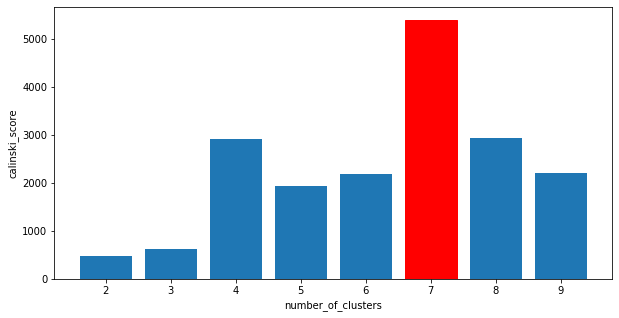

The optimal number of clusters is 7.


In [267]:
plt.figure(figsize=(10,5))
bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
plt.xlabel(results.columns[0])
plt.ylabel(results.columns[1]) 
bars[results["calinski_score"].idxmax()].set_color("r")
plt.show()
plt.close()
print("The optimal number of clusters is {}.".format(optimalNumberOfClusters))

# Ausreißer eliminieren

**Todo**: *Prüfen in wie weit hierdurch wie bei Isolation Forest die exchange addresses rausgehauen werden.*

In [268]:

# def remove_outliers(featureValues, featureValues_std_pca, kmeans, threshold):
    
#     featureValues_std_pca_within_cluster_new = pd.DataFrame();
#     featureValues_within_cluster_new = pd.DataFrame();
#     labels_new = [];

#     for clusterNumber, centroid in enumerate(kmeans.cluster_centers_):
        
#         featureValues_std_pca_within_cluster = featureValues_std_pca[kmeans_opt.labels_ == clusterNumber];
#         featureValues_within_cluster = featureValues[kmeans_opt.labels_ == clusterNumber];
            
#         distances = featureValues_std_pca_within_cluster - centroid;
#         distances_norm = np.linalg.norm(distances, axis=1);

#         maxDistance = threshold * np.linalg.norm(featureValues_std_pca_within_cluster.std())
        
#         keep = distances_norm <= maxDistance
        
#         featureValues_std_pca_within_cluster_new = featureValues_std_pca_within_cluster_new.append(featureValues_std_pca_within_cluster[keep])
#         featureValues_within_cluster_new = featureValues_within_cluster_new.append(featureValues_within_cluster[keep])
#         labels_new.extend([clusterNumber for i in featureValues_within_cluster[keep].iterrows()])
        
#     return featureValues_std_pca_within_cluster_new, featureValues_within_cluster_new, labels_new

In [269]:
# kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
# kmeans_opt.fit(featureValues_std_pca)

In [270]:
# from sklearn.metrics import calinski_harabaz_score as ch_score

# thresholds = np.linspace(.01,3, 20)

# test = [remove_outliers(featureValues, featureValues_std_pca, kmeans_opt,t) for t in thresholds]

# scores= []

# for (res1, res2, labels) in test:
#     scores.append(metrics.calinski_harabasz_score(res2, labels)) 

In [271]:
# plt.plot(thresholds, scores)
# plt.title('Calinski Harabaz Scores as std threshold changes')

In [272]:
# optimalThreshold = thresholds[np.argmax(scores)]
# print("The threshold leading to the highest Calinski Harabaz Score is", optimalThreshold)

In [273]:
# featureValues, featureValues_std_pca, labels = remove_outliers(featureValues, featureValues_std_pca, kmeans_opt, optimalThreshold)
# featureValues_std_pca = pd.DataFrame(featureValues_std_pca)
# featureValues = pd.DataFrame(featureValues)

# Visualisierung: T-SNE

In [274]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# featureValues_std_pca_out_tsne = tsne.fit_transform(featureValues_std_pca_out)
# featureValues_std_pca_out_tsne = pd.DataFrame(featureValues_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# featureValues_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [275]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# featureValues_std_pca_out_tsne["Label"] = kmeans_opt.labels_
# featureValues_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=featureValues_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

## Visualisierung PCA 3D Diagramm

In [276]:
# from mpl_toolkits.mplot3d import Axes3D
# # To getter a better understanding of interaction of the dimensions
# # plot the first three PCA dimensions
# fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig, elev=-150, azim=110)
# X_reduced = PCA(n_components=3).fit_transform(featureValues_out)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_,
#            cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

In [277]:
# optimalNumberOfClusters = 2 # tmp
kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
kmeans_opt.fit(featureValues_std_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

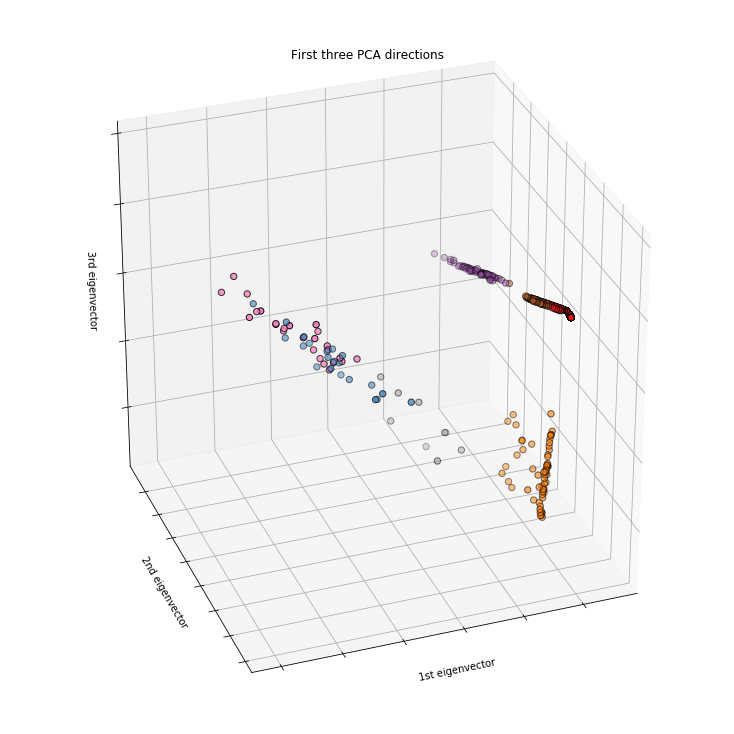

In [278]:
from mpl_toolkits.mplot3d import Axes3D;
# To getter a better understanding of interaction of the dimensions;
# plot the first three PCA dimensions;
fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
featureValues_std = scaler.fit_transform(featureValues);
featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
X_reduced = PCA(n_components=3).fit_transform(featureValues_std);


ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_, cmap=plt.cm.Set1, edgecolor='k', s=40);
ax.set_title("First three PCA directions");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);

# Visualisierung: Vergleich der Ballungen

In [292]:
clusterMeans = []
cluster_size = {}

for i, center in enumerate(kmeans_opt.cluster_centers_):
    within_cluster_featureValues = featureValues[kmeans_opt.labels_==i]
    cluster_size[i] = len(within_cluster_featureValues)
    clusterMeans.append(within_cluster_featureValues.mean())

cluster_data = pd.DataFrame(clusterMeans)
cluster_data = cluster_data / cluster_data.sum()

In [293]:
cluster_data["cluster_size"] = list(cluster_size.values())
cluster_data = cluster_data.sort_values(by="cluster_size", ascending=False)
cluster_data = cluster_data.reset_index(drop=True)

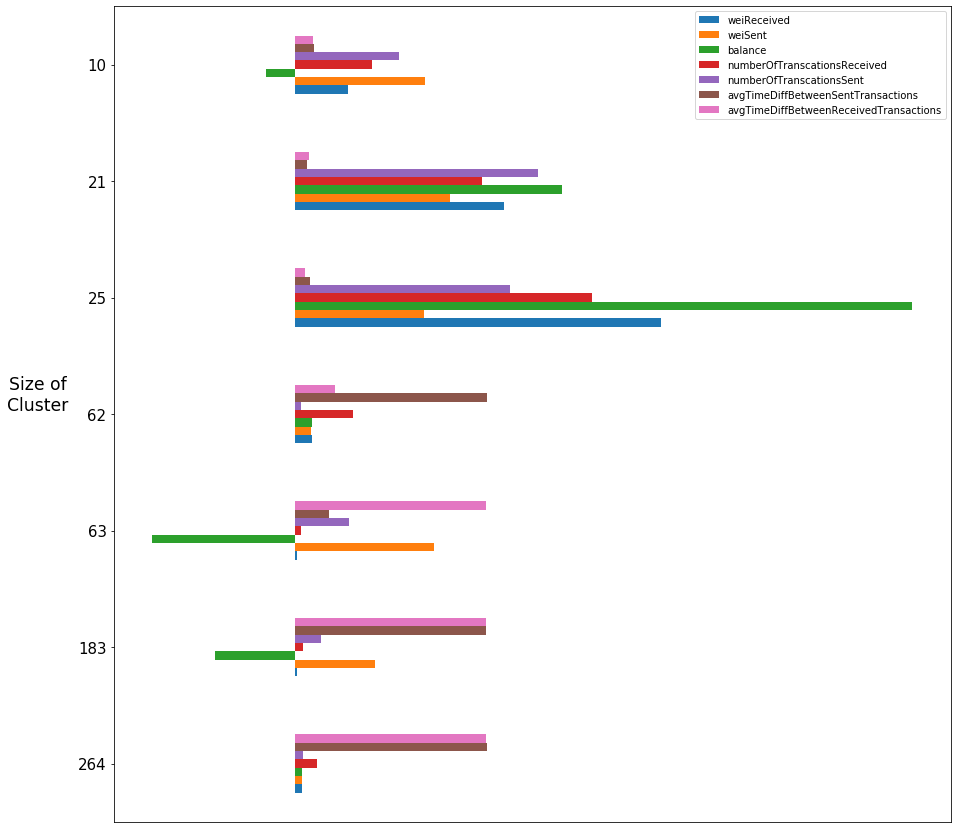

In [298]:
ax = cluster_data.plot.barh(x="cluster_size" ,figsize=(15,15))

ax.tick_params(
    which="major",
    axis='x', 
    bottom=False
    )

ax.tick_params(
    which="major",
    axis='y', 
    labelsize=15
    ) 

ylabels = ax.get_yticklabels()

ax.set_xticklabels([])
ylabel = ax.set_ylabel("Size of\nCluster", fontsize="xx-large", rotation=0, labelpad=40)

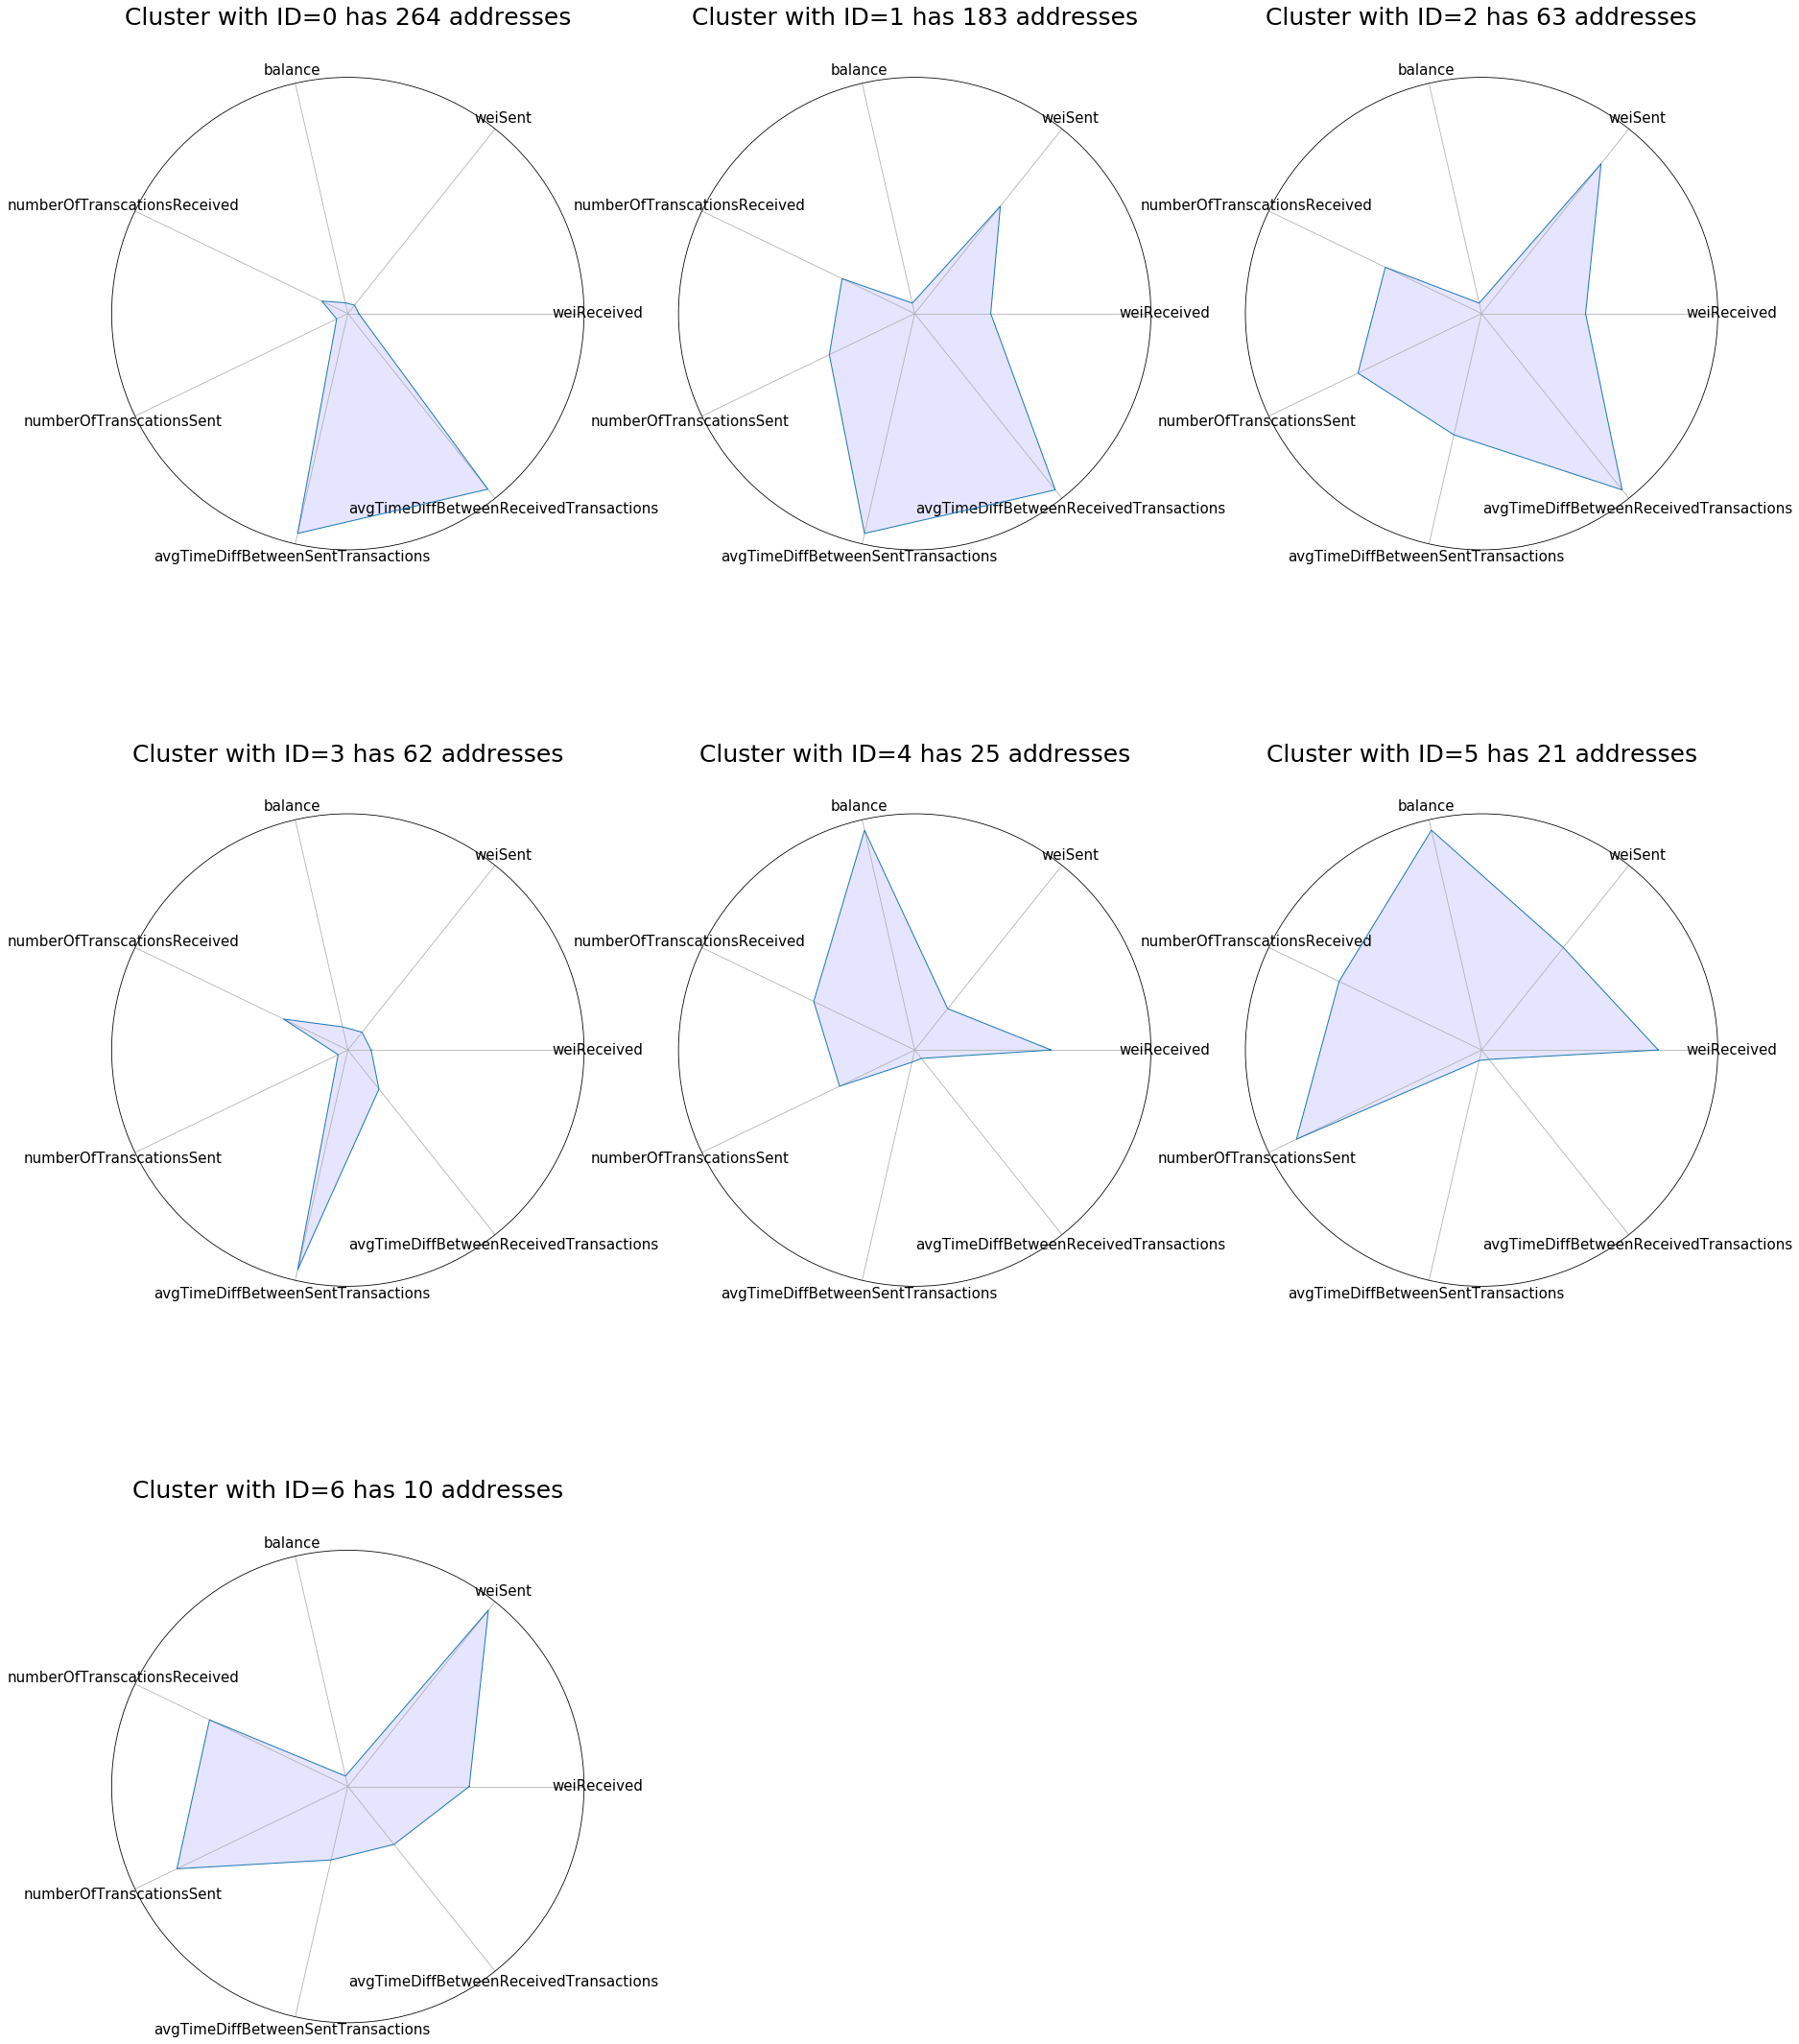

In [349]:
from math import pi

cluster_size = cluster_data.loc[:, "cluster_size"]
cluster_data_tmp = cluster_data.drop("cluster_size", axis=1)

categories=list(x_tmp)
N = len(categories)

values = []

for i,v in enumerate(x_tmp.iterrows()): 
    tmp_values = cluster_data_tmp.loc[i].values.tolist()
    tmp_values += tmp_values[:1]
    values.append(tmp_values)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
angles
 
plt.figure(figsize=(30,40))

for i,values in enumerate(values):
#     print(cluster_size[i])
    position = int("".join([str(33), str(i + 1)]))
    axis = plt.subplot(position, polar=True)
    plt.sca(axis)
    plt.xticks(angles[:-1], categories, size=15)
    plt.yticks([])
    axis.plot(angles, values, linewidth=1, linestyle='solid')
    axis.fill(angles, values, 'b', alpha=0.1)
#     a.text(0.1,0.1, cluster_size[i], color = "red", size=20)
    axis.set_title("Cluster with ID={} has {} addresses".format(i, cluster_size[i]), color = "black", size=25, loc="center", pad=30)


# Recall, Precision und F1 score für das Clustering

In [299]:
exchanges = [(a, "e") for i, a in enumerate(addresses) if a.startswith("exchange")]
speculators = [(a, "x") for i, a in enumerate(addresses) if a.startswith("speculator")]

exchanges = pd.DataFrame(zip(*exchanges)).T
speculators = pd.DataFrame(zip(*speculators)).T

exchanges.columns = ["address", "should_actual_be_in_cluster"]
speculators.columns = ["address", "should_actual_be_in_cluster"]

exchanges = exchanges.set_index("address")
speculators = speculators.set_index("address")

# addresses[kmeans_opt.labels_ == 2]

tmp = pd.DataFrame(zip(addresses, kmeans_opt.labels_), columns=["address", "is_in_cluster"])
tmp = tmp.set_index("address")

tmp1 = exchanges.append(speculators)

tmp1 = tmp1.join(tmp, on="address", how="inner")

cluster_list = []
for i in tmp1["is_in_cluster"].unique():
    cluster_list.append(list(tmp1[tmp1["is_in_cluster"] == i]["should_actual_be_in_cluster"]))



In [301]:
import collections as collections
from math import factorial as fac

def b(x, y):
    try:
        binom = fac(x) // fac(y) // fac(x - y)
    except ValueError:
        binom = 0
    return binom

Counter = collections.Counter

num_doc= 0
TP = 0
FP = 0
FN = 0
TN = 0
c_list = []
for c in range(0, len(cluster_list)): 
    # calculating num_doc count...
    num_doc += len(cluster_list[c])

    c = Counter(cluster_list[c])
    c_list.append(c)
    TP += b(c["e"], 2) 
    
# Calculate False Positives
    
for c in range(0, len(cluster_list)): 
    c = Counter(cluster_list[c])
    FP += c["e"] * c["x"]

# Add all the cluster together
sum = Counter()
for c in c_list:
    sum += c

# calculating FN...
for ct in c_list:
    fn_temp = 0 

    fn_temp += ct["e"]*(sum["e"]-ct["e"])
    sum -= ct
    FN += fn_temp


print("num_doc is %d " % num_doc)
print("TP is %d " % TP)
print("FP is %d " % FP)
print("FN is %d " % FN)
print("TN is %d " % TN)

Precision = TP/(TP+FP)
print("Precision is %.2f " % Precision)

Recall = TP/(TP+FN)
print("Recall is %.2f " % Recall)

F1=(2*Recall*Precision)/(Recall+Precision)
print("F1 is %.2f " % F1)



num_doc is 628 
TP is 516 
FP is 24 
FN is 709 
TN is 0 
Precision is 0.96 
Recall is 0.42 
F1 is 0.58 


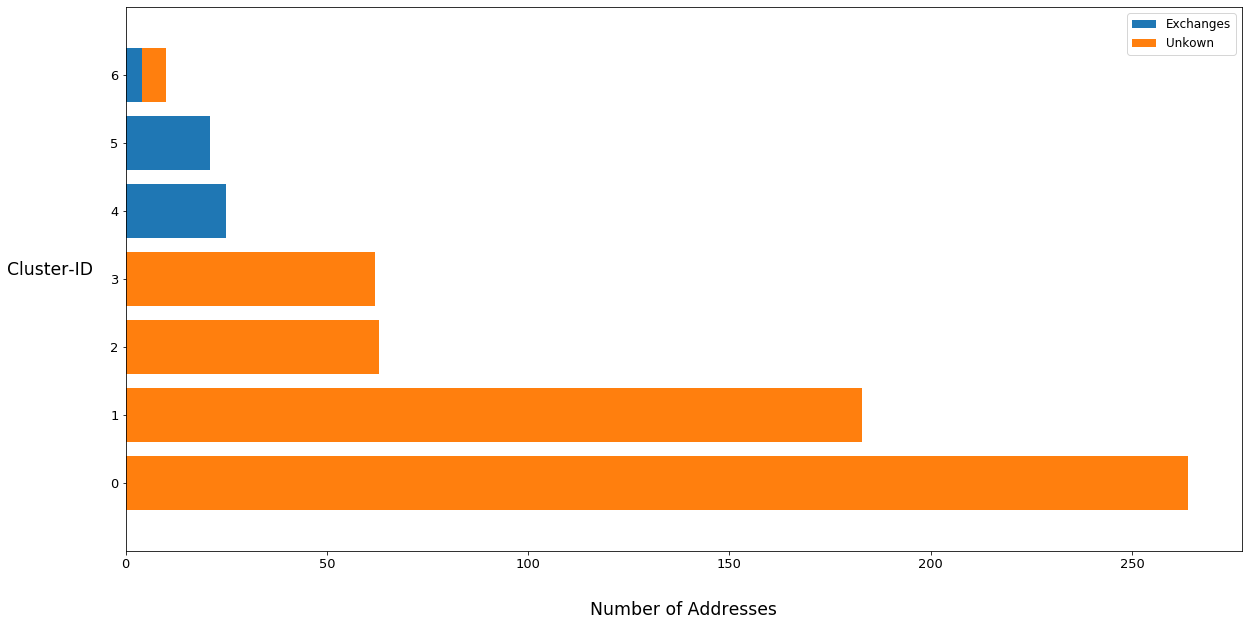

In [340]:
fig, ax = plt.subplots(figsize= (20,10))

cluster_list.sort(key=len, reverse = True)
ind = range(0, len(cluster_list))

numberOfExchanges = [Counter(cl)["e"] for cl in cluster_list]
numberOfSpeculators = [Counter(cl)["x"] for cl in cluster_list]

line1 = ax.barh(ind, numberOfExchanges)
line2 = ax.barh(ind, numberOfSpeculators, left=numberOfExchanges)

yticklabels = ax.get_yticklabels()

start, end = ax.get_ylim()
ax.set_ylim(-1,7)

ax.yaxis.set_ticks(np.arange(0, 7, 1))

ax.legend((line1, line2), ('Exchanges', 'Unkown'), loc="upper right", fontsize="larger")

yticklabels = ax.set_yticklabels(ind)

ax.tick_params(
    which="major",
    axis='both', 
    labelsize=13
    ) 
ylabel = ax.set_ylabel("Cluster-ID", fontsize="xx-large", rotation=0, labelpad=60)
ylabel = ax.set_xlabel("Number of Addresses", fontsize="xx-large", rotation=0, labelpad=30)


# Verifiziere das Funktionieren des Entscheidungsmodells mit bekannten Adressen

# Temporary stuff

In [ ]:
import collections as collections

Counter = collections.Counter

cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
num_doc= 0
positives = 0
negatives = 0
TP = 0
FP = 0
FN = 0
TN = 0
c_list = []
for c in range(0, len(cluster_list)): 
    # calculating num_doc count...
    num_doc += len(cluster_list[c])

    # calculating positives...
    positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

    # calculating TP...
    c = Counter(cluster_list[c])
    c_list.append(c)
    tp_temp = 0 
    for k,v in dict(c).items():
        if v>1:
            tp_temp += (v*(v-1))/2
    TP += tp_temp 

FP = positives - TP
negatives = ((num_doc*(num_doc-1))/2) - positives
# Add all the cluster together
sum = Counter()

for c in c_list:
    sum += c

# calculating FN...
for ct in c_list:
    fn_temp = 0 
    for k,v in dict(ct).items():
        fn_temp += v*(sum[k]-v)
    sum -= ct
    FN += fn_temp
TN = negatives -FN
print("num_doc is %d " % num_doc)
print("positives is %d " % positives)
print("TP is %d " % TP)
print("FP is %d " % FP)
print("FN is %d " % FN)
print("TN is %d " % TN)

Precision = TP/(TP+FP)
print("Precision is %.2f " % Precision)

Recall = TP/(TP+FN)
print("Recall is %.2f " % Recall)

F1=(2*Recall*Precision)/(Recall+Precision)
print("F1 is %.2f " % F1)

Problem: Mit dem obigen Algorithmus wird die Güte des Clustering Algorithmus ingesamt bestimmt. Ich will aber nur die Güte des Clustering Modell anhand der Exchange Adressen bestimme.

Lösung?: (#Paare im selben cluster) / (#Paare in unterschiedlichen Clustern)

In [ ]:
import collections as collections

Counter = collections.Counter

cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
num_doc= 0
positives = 0
negatives = 0
TP = 0
FP = 0
FN = 0
TN = 0
c_list = []
for c in range(0, len(cluster_list)): 
    # calculating num_doc count...
    num_doc += len(cluster_list[c])

    # calculating positives...
    positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

    # calculating TP...
    c = Counter(cluster_list[c])
    c_list.append(c)
    tp_temp = 0 
    for k,v in dict(c).items():
        if v>1:
            tp_temp += (v*(v-1))/2
    TP += tp_temp 

FP = positives - TP
negatives = ((num_doc*(num_doc-1))/2) - positives
# Add all the cluster together
sum = Counter()

for c in c_list:
    sum += c

# calculating FN...
for ct in c_list:
    fn_temp = 0 
    for k,v in dict(ct).items():
        fn_temp += v*(sum[k]-v)
    sum -= ct
    FN += fn_temp
TN = negatives -FN
print("num_doc is %d " % num_doc)
print("positives is %d " % positives)
print("TP is %d " % TP)
print("FP is %d " % FP)
print("FN is %d " % FN)
print("TN is %d " % TN)

Precision = TP/(TP+FP)
print("Precision is %.2f " % Precision)

Recall = TP/(TP+FN)
print("Recall is %.2f " % Recall)

F1=(2*Recall*Precision)/(Recall+Precision)
print("F1 is %.2f " % F1)